This script creates embeddings of the different data features and representations exported from .feature_extraction.ipynb

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

import umap
from umap.umap_ import nearest_neighbors
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

from mpl_toolkits.mplot3d import Axes3D

In [19]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))


In [21]:
calls_df["log_padded_spectrogram"].iloc[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()

1171


Only keep a random subset of recruitment, departure and contact calls to balance the data

In [23]:
subset_size = 500

subsample_sizes = {
    'recruitment': subset_size,
    'contact': subset_size,
    'departure': subset_size,
}

# Randomly subsample per call type
def subsample_group(group):
    call_type = group.name  # Group name corresponds to call type
    if call_type in subsample_sizes:
        return group.sample(n=subsample_sizes[call_type], random_state=42)
    return group  # Return untouched if no subsampling is needed

# Group by type and apply subsampling
calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_1215/4077462294.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_1215/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

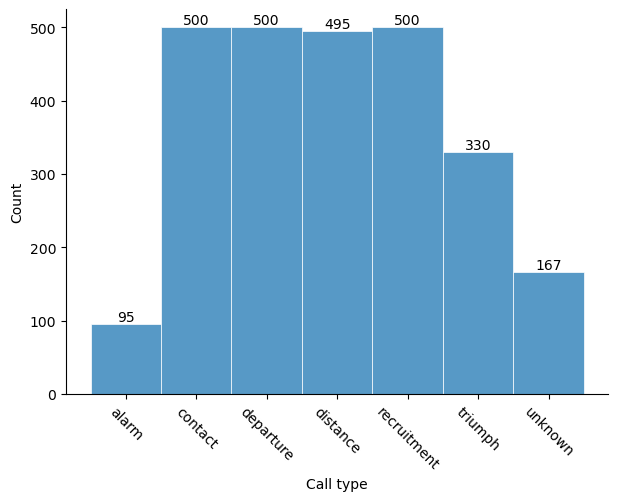

In [24]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

In [25]:
n_neighbors = 15

#### Analyze predefined audio features

In [26]:
features_scaled = StandardScaler().fit_transform(calls_df.drop(columns=["call_type", "track_ID", "clip_ID", "goose_ID", "waveform", "sr", "filepath", "log_duration", "normalized_log_length", "log_target_duration", "log_padded_spectrogram", "padded_spectrogram", "spectrogram"]))
# considering scaling: https://github.com/lmcinnes/umap/issues/66

In [27]:
nn_results_paf = nearest_neighbors(
    features_scaled,
    n_neighbors=n_neighbors,
    metric="euclidean",
    metric_kwds={},
    angular=False,
    random_state=42,
    verbose=True,
)  

Tue Dec 10 10:55:47 2024 Finding Nearest Neighbors
Tue Dec 10 10:55:47 2024 Building RP forest with 8 trees
Tue Dec 10 10:55:47 2024 NN descent for 11 iterations
	 1  /  11
	 2  /  11
	 3  /  11
	Stopping threshold met -- exiting after 3 iterations
Tue Dec 10 10:55:47 2024 Finished Nearest Neighbor Search


In [28]:
def display_nearest_neighbours(nn_graph, df, n_examples=5, n_neighbors=15):
    fig, axs = plt.subplots(nrows=n_examples, ncols=n_neighbors, figsize=(n_neighbors, n_examples))

    for i in range(n_examples):
        for j in range(n_neighbors):
            axs[i, j].matshow(df.iloc[nn_graph[0][i][j]]["log_padded_spectrogram"], origin="lower", cmap="magma", aspect="auto")
            axs[i, j].axis("off")
    plt.tight_layout()
    plt.show()

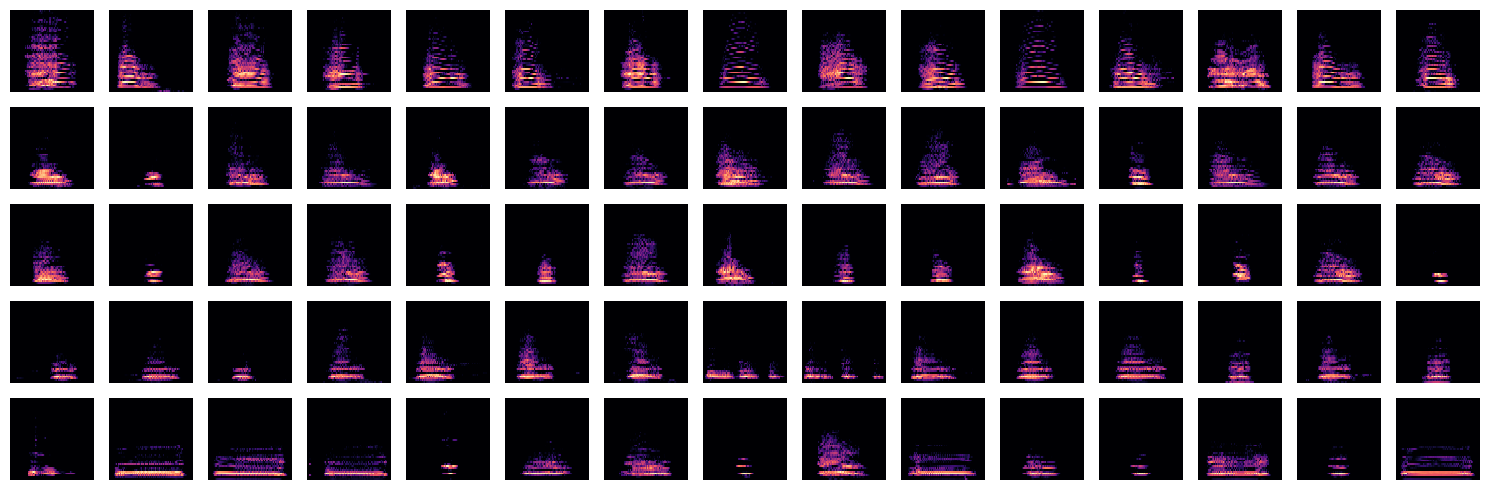

In [29]:
display_nearest_neighbours(nn_results_paf, calls_df)

In [30]:
embeddings_paf = umap.UMAP(precomputed_knn=nn_results_paf, n_neighbors=15, n_components=2, min_dist=0.1).fit_transform(features_scaled)

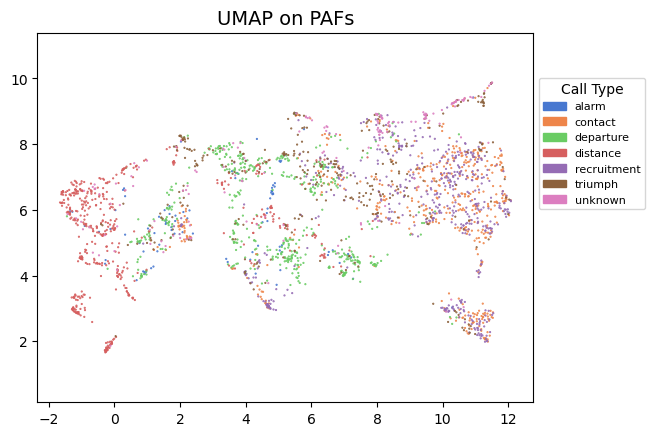

In [31]:
unique_call_types = calls_df["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_call_types))
call_type_to_color = {call_type: color for call_type, color in zip(unique_call_types, color_palette)}

# Assign colors to points
colors = [call_type_to_color[call_type] for call_type in calls_df["call_type"]]

# Scatter plot
plt.scatter(
    embeddings_paf[:, 0],
    embeddings_paf[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on PAFs', fontsize=14)

# Legend
legend_patches = [Patch(color=color, label=call_type) for call_type, color in call_type_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)

plt.show()

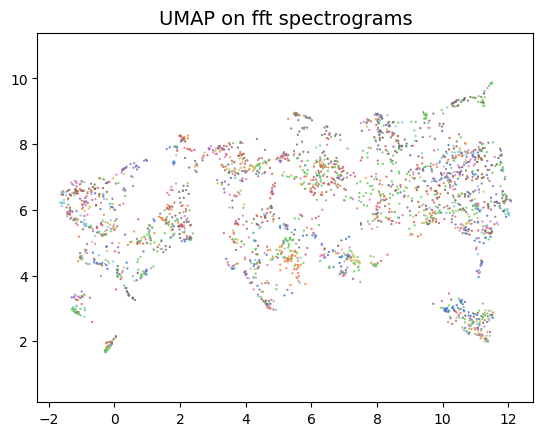

In [32]:
unique_goose_ids = calls_df["goose_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {goose_id: color for goose_id, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[goose_id] for goose_id in calls_df["goose_ID"]]

# Scatter plot
plt.scatter(
    embeddings_paf[:, 0],
    embeddings_paf[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
# legend_patches = [Patch(color=color, label=goose_id) for goose_id, color in goose_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Goose ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

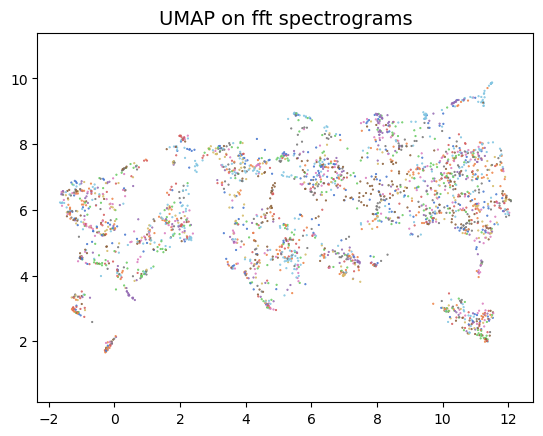

In [33]:
unique_track_ids = calls_df["track_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_track_ids))
goose_id_to_color = {track_id: color for track_id, color in zip(unique_track_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[track_id] for track_id in calls_df["track_ID"]]

# Scatter plot
plt.scatter(
    embeddings_paf[:, 0],
    embeddings_paf[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

plt.show()

#### Analyze spectrograms

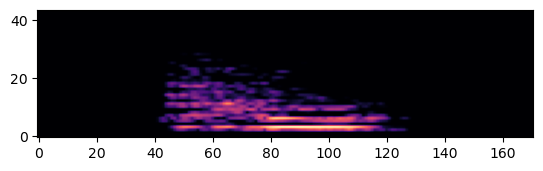

(44, 171)


In [36]:
# longest call
#vocalization = calls_df.loc[calls_df["duration"].idxmax()]
# random call
vocalization = calls_df.iloc()[np.random.randint(0, len(calls_df))]

plt.imshow(vocalization["log_padded_spectrogram"], origin="lower", cmap="magma")
plt.show()
print(vocalization["log_padded_spectrogram"].shape)

In [37]:
labels_and_spectrograms = []
for idx, row in calls_df.iterrows():
    labels_and_spectrograms.append([row["call_type"], row["track_ID"], row["goose_ID"], *row["log_padded_spectrogram"].flatten()])

In [38]:
column_names = ["call_type", "track_ID", "goose_ID"]
for i in range(len(calls_df.iloc[0]["log_padded_spectrogram"].flatten())):
    column_names.append(i)

In [39]:
labels_and_spectrograms_df = pd.DataFrame(labels_and_spectrograms, columns=column_names, index=None) 
labels_and_spectrograms_df.head()

,call_type,track_ID,goose_ID,0,1,2,3,4,5,6,...,7514,7515,7516,7517,7518,7519,7520,7521,7522,7523
0,alarm,GT00052,Dagobert,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,alarm,GT00058,Besenstiel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,alarm,GT00989,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,alarm,GT00055,Lausbursch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,alarm,GT00989,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### UMAP

In [40]:
labels_and_spectrograms_scaled = StandardScaler().fit_transform(labels_and_spectrograms_df.drop(columns=["call_type", "track_ID", "goose_ID"]))

In [41]:
nn_results_spec = nearest_neighbors(
    labels_and_spectrograms_scaled,
    n_neighbors=n_neighbors,
    metric="euclidean",
    metric_kwds={},
    angular=False,
    random_state=42,
    verbose=True,
)

Tue Dec 10 10:58:16 2024 Finding Nearest Neighbors
Tue Dec 10 10:58:16 2024 Building RP forest with 8 trees
Tue Dec 10 10:58:17 2024 NN descent for 11 iterations
	 1  /  11
	 2  /  11
	 3  /  11
	 4  /  11
	Stopping threshold met -- exiting after 4 iterations
Tue Dec 10 10:58:17 2024 Finished Nearest Neighbor Search


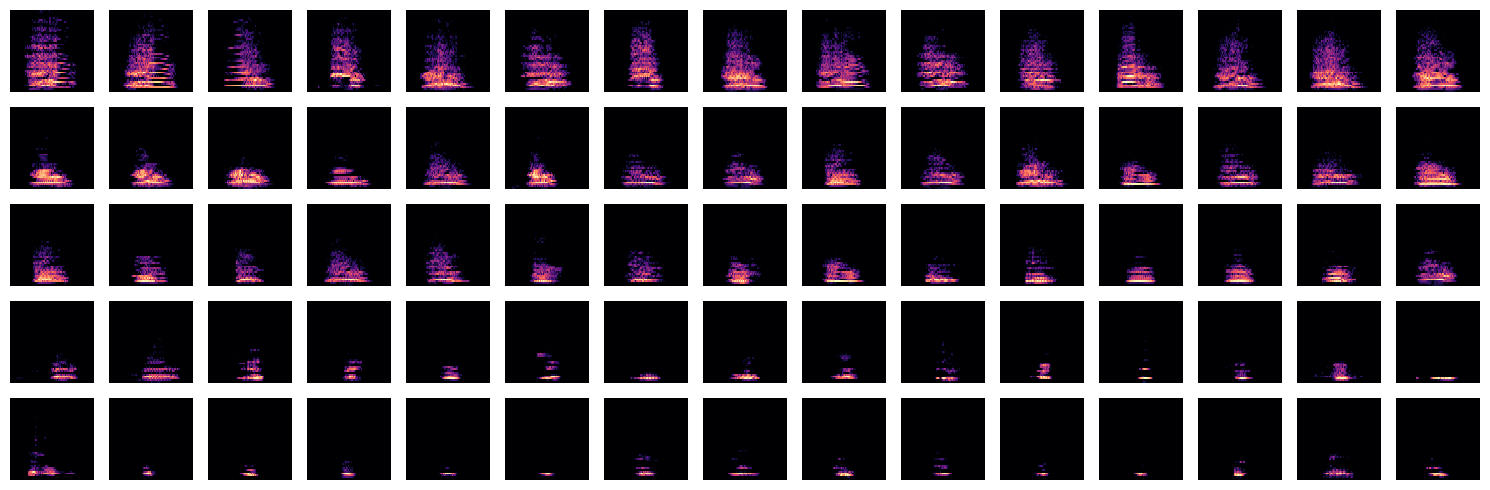

In [42]:
display_nearest_neighbours(nn_results_spec, calls_df)

In [43]:
embeddings_spec = umap.UMAP(precomputed_knn=nn_results_spec, n_neighbors=n_neighbors, n_components=2, min_dist=0.1).fit_transform(labels_and_spectrograms_scaled)

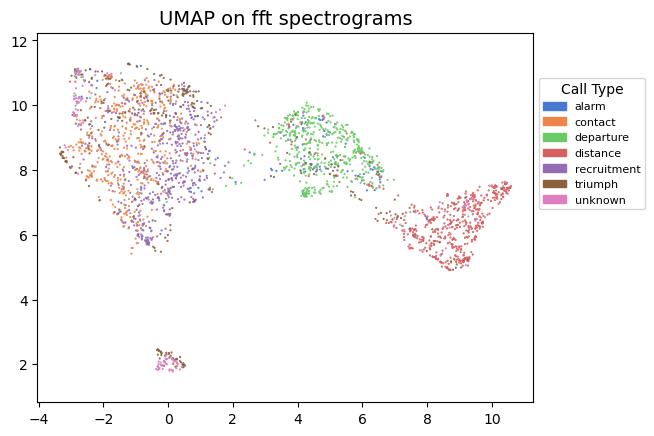

In [44]:
unique_call_types = labels_and_spectrograms_df["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_call_types))
call_type_to_color = {call_type: color for call_type, color in zip(unique_call_types, color_palette)}

# Assign colors to points
colors = [call_type_to_color[call_type] for call_type in labels_and_spectrograms_df["call_type"]]

# Scatter plot
plt.scatter(
    embeddings_spec[:, 0],
    embeddings_spec[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
legend_patches = [Patch(color=color, label=call_type) for call_type, color in call_type_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)

plt.show()

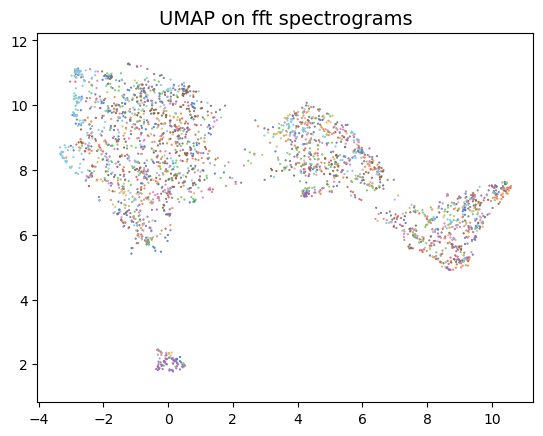

In [45]:
unique_track_ids = labels_and_spectrograms_df["track_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_track_ids))
track_id_to_color = {track_id: color for track_id, color in zip(unique_track_ids, color_palette)}

# Assign colors to points
colors = [track_id_to_color[track_id] for track_id in labels_and_spectrograms_df["track_ID"]]

# Scatter plot
plt.scatter(
    embeddings_spec[:, 0],
    embeddings_spec[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# legend_patches = [Patch(color=color, label=track_id) for track_id, color in track_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Track_ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

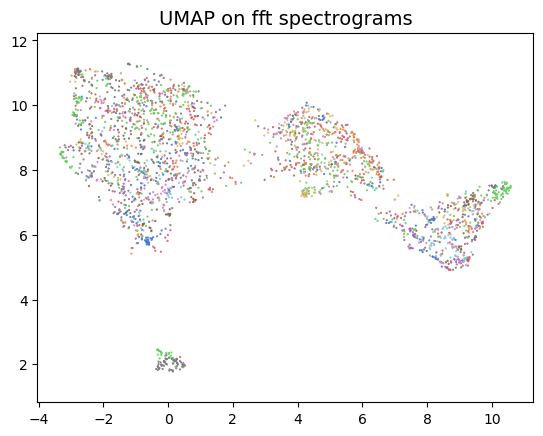

In [ ]:
unique_goose_ids = labels_and_spectrograms_df["goose_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {goose_id: color for goose_id, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[goose_id] for goose_id in labels_and_spectrograms_df["goose_ID"]]

# Scatter plot
plt.scatter(
    embeddings_spec[:, 0],
    embeddings_spec[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms - colored by goose ID', fontsize=14)

# Legend
# legend_patches = [Patch(color=color, label=goose_id) for goose_id, color in goose_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Goose ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

In [47]:
embeddings3d = umap.UMAP(precomputed_knn=nn_results_spec, n_neighbors=n_neighbors, n_components=3, min_dist=0.1).fit_transform(labels_and_spectrograms_scaled)

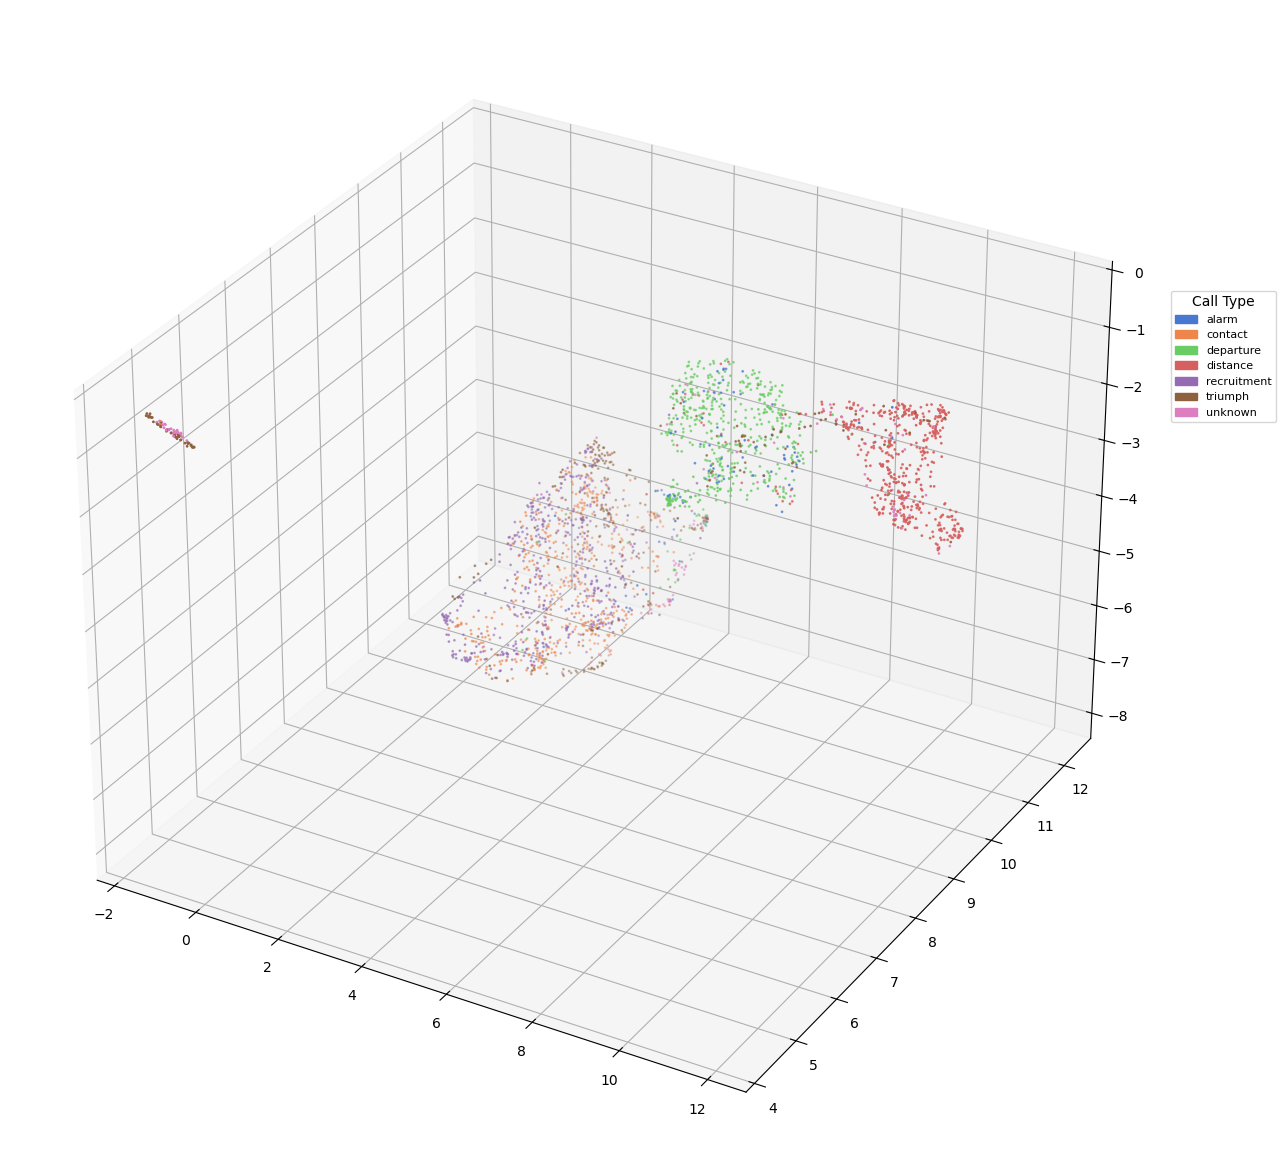

In [48]:
unique_goose_ids = labels_and_spectrograms_df["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {call_type: color for call_type, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[call_type] for call_type in labels_and_spectrograms_df["call_type"]]

# for 3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter( 
    embeddings3d[:, 0],
    embeddings3d[:, 1],
    embeddings3d[:, 2],
    c=colors,
    s=1)

legend_patches = [Patch(color=color, label=call_type) for call_type, color in goose_id_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)

#### HDBSCAN

In [49]:
import hdbscan

##### cluster PAFs

In [50]:
clusters_paf = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10, cluster_selection_epsilon=1, prediction_data=True)
clusters_paf.fit(features_scaled)

HDBSCAN(cluster_selection_epsilon=1, min_samples=10, prediction_data=True)

In [51]:
clusters_paf.labels_.max()

np.int64(5)

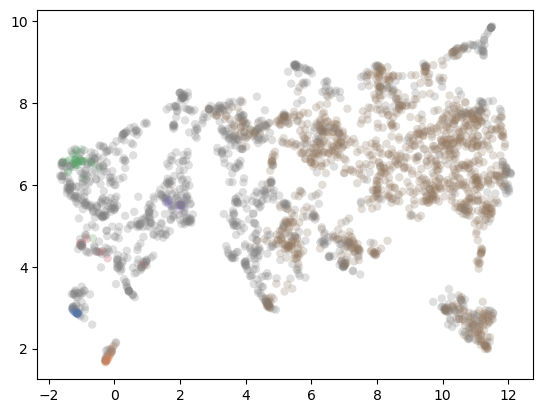

In [52]:
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters_paf.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusters_paf.probabilities_)]
plt.scatter(*embeddings_paf.T, linewidth=0, c=cluster_member_colors, alpha=0.25)

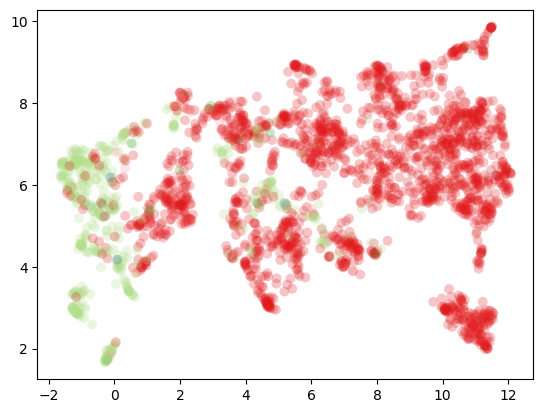

In [53]:
soft_clusters = hdbscan.all_points_membership_vectors(clusters_paf)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*embeddings_paf.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

<Axes: ylabel='$\\lambda$ value'>

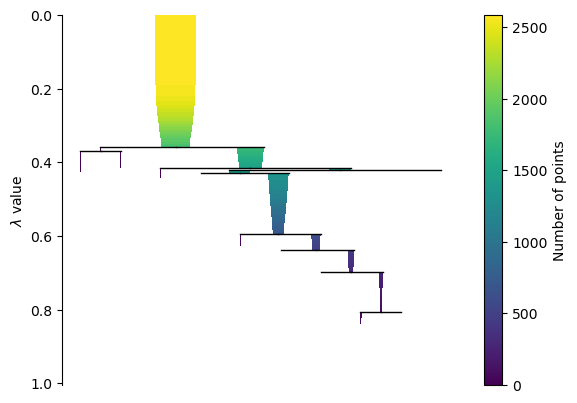

In [54]:
clusters_paf.condensed_tree_.plot()

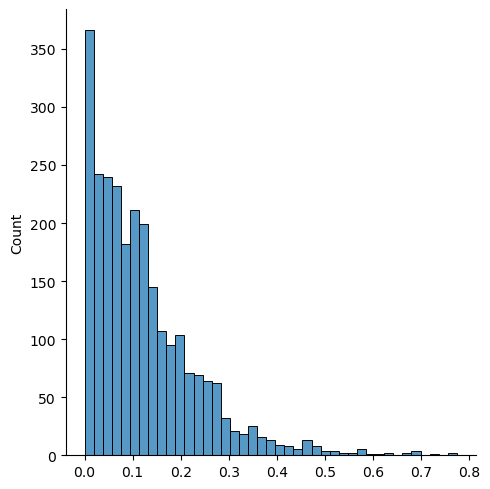

In [55]:
sns.displot(clusters_paf.outlier_scores_[np.isfinite(clusters_paf.outlier_scores_)], rug=False)

##### Cluster the embeddings

In [56]:
clusters_paf_embeddings = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=100, cluster_selection_epsilon=1, prediction_data=True)
clusters_paf_embeddings.fit(embeddings_paf)

HDBSCAN(cluster_selection_epsilon=1, min_cluster_size=50, min_samples=100,
        prediction_data=True)

In [57]:
clusters_paf_embeddings.labels_.max()

np.int64(1)

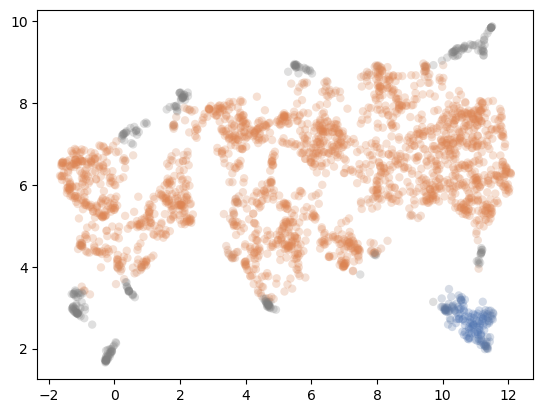

In [58]:
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters_paf_embeddings.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusters_paf_embeddings.probabilities_)]
plt.scatter(*embeddings_paf.T, linewidth=0, c=cluster_member_colors, alpha=0.25)

<Axes: ylabel='$\\lambda$ value'>

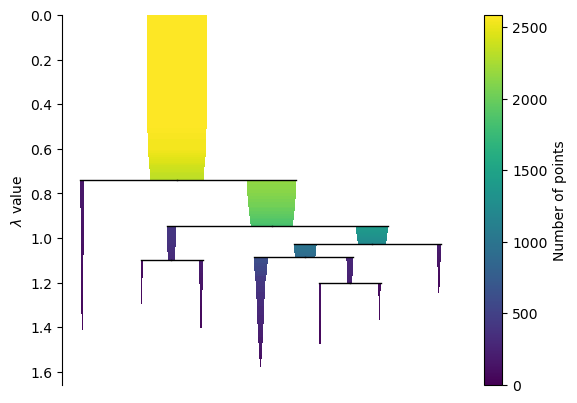

In [59]:
clusters_paf_embeddings.condensed_tree_.plot()

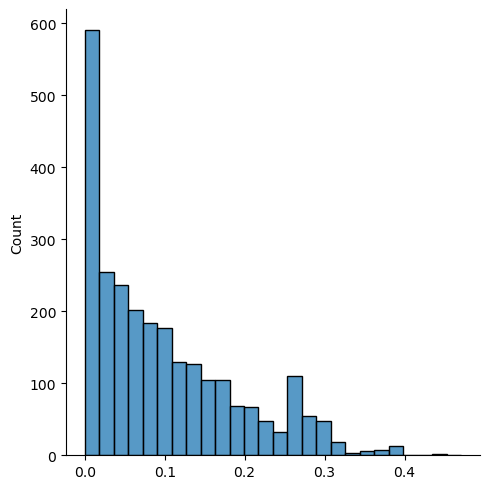

In [60]:
sns.displot(clusters_paf_embeddings.outlier_scores_[np.isfinite(clusters_paf_embeddings.outlier_scores_)], rug=False)

##### Cluster spectrogram embeddings

In [61]:
clusters_spec = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=100, cluster_selection_epsilon=.7, prediction_data=True)
clusters_spec.fit(embeddings_spec)

HDBSCAN(cluster_selection_epsilon=0.7, min_cluster_size=25, min_samples=100,
        prediction_data=True)

In [62]:
clusters_spec.labels_.max()

np.int64(2)

In [63]:
clusters_spec.probabilities_

array([0.83076756, 0.9890526 , 1.        , ..., 0.8224934 , 0.        ,
       0.        ])

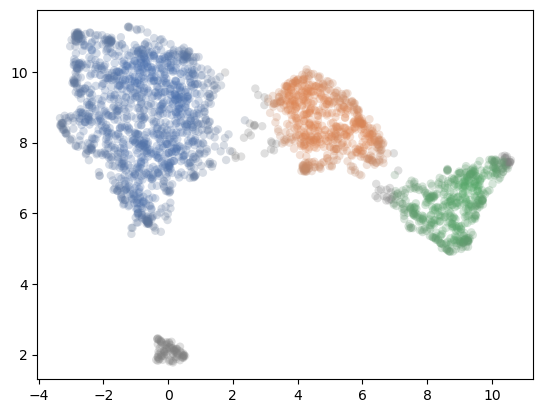

In [64]:
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusters_spec.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusters_spec.probabilities_)]
plt.scatter(*embeddings_spec.T, linewidth=0, c=cluster_member_colors, alpha=0.25)

<Axes: ylabel='$\\lambda$ value'>

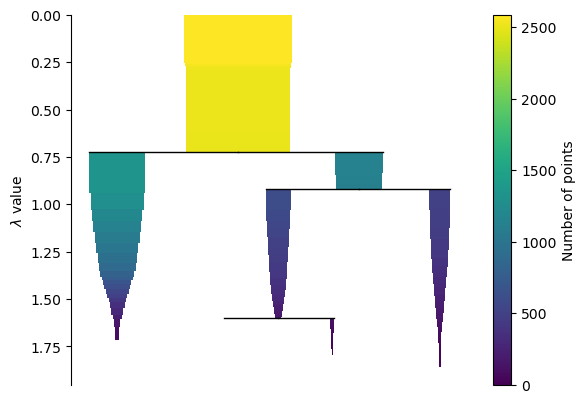

In [65]:
clusters_spec.condensed_tree_.plot()

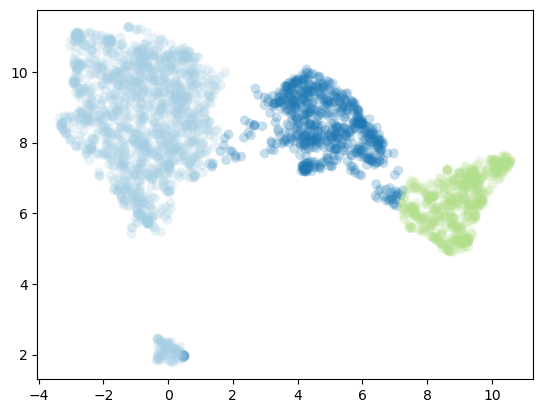

In [66]:
soft_clusters = hdbscan.all_points_membership_vectors(clusters_spec)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*embeddings_spec.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

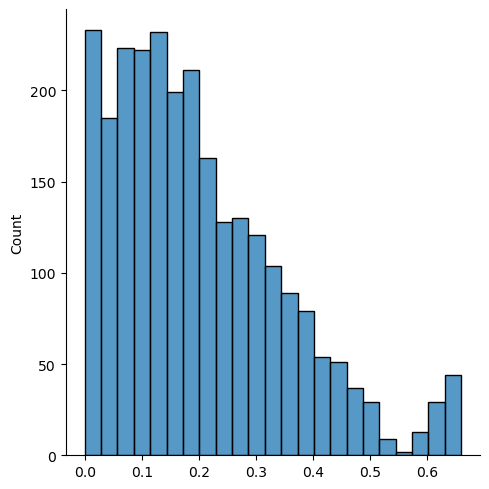

In [67]:
sns.displot(clusters_spec.outlier_scores_[np.isfinite(clusters_spec.outlier_scores_)], rug=False)

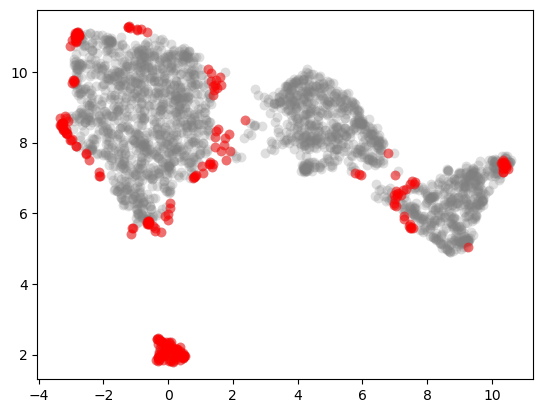

In [68]:
threshold = pd.Series(clusters_spec.outlier_scores_).quantile(0.9)
outliers = np.where(clusters_spec.outlier_scores_ > threshold)[0]
plt.scatter(*embeddings_spec.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*embeddings_spec[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)